In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from itertools import product
from functools import reduce

## Data preparation

In [3]:
# define labels
MUST_HAVE_LABELS = ("endemic", "non_case")
DATA_LABELS = ("one", "two", "three") + MUST_HAVE_LABELS

In [4]:
# define coordinate system
df = pd.concat(
    [
        pd.DataFrame(columns=["x1", "x2"], data=product(range(5), range(5))),
        pd.DataFrame(columns=DATA_LABELS),
    ]
)

In [5]:
df.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# read in data
one = [0] * 5 + [0, 1, 1, 0, 0] + [0, 0, 1, 0, 0] + [0] * 10
two = (
    [
        0,
        0,
        1,
        1,
        1,
    ]
    + [0] * 10
    + [0, 0, 0, 1, 0]
    + [0] * 5
)
three = [0] * 15 + [0, 0, 0, 1, 2] + [0] * 5
endemic = (
    [0] * 5 + [1, 0, 0, 0, 0] + [0, 1, 0, 0, 0] + [4, 0, 0, 0, 1] + [2, 0, 0, 0, 1]
)

df_structured_data = df.assign(one=one, two=two, three=three, endemic=endemic)

In [7]:
df_structured_data.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,NaN
1,0.0,1.0,0,0,0,0,NaN
2,0.0,2.0,0,1,0,0,NaN
3,0.0,3.0,0,1,0,0,NaN
4,0.0,4.0,0,1,0,0,NaN


In [8]:
# pad dummy-non-cases
no_assigned_label = (
    df_structured_data.loc[
        :, [label for label in DATA_LABELS if label != "non-case"]
    ].sum(axis=1)
    == 0
)
df_padded = df_structured_data.assign(
    non_case=lambda x: x.loc[:, ["non_case"]].mask(no_assigned_label, 1).fillna(0)
)

In [9]:
df_padded.tail()

,x1,x2,one,two,three,endemic,non_case
20,4.0,0.0,0,0,0,2,0
21,4.0,1.0,0,0,0,0,1
22,4.0,2.0,0,0,0,0,1
23,4.0,3.0,0,0,0,0,1
24,4.0,4.0,0,0,0,1,0


In [9]:
# calculate disease probability per cell, p(d_i| x)
df_padded.loc[:, DATA_LABELS] = df_padded.loc[:, DATA_LABELS].div(
    df_padded.loc[:, DATA_LABELS].sum(axis=1), axis=0
)

In [10]:
df_padded.tail()

,x1,x2,one,two,three,endemic,non_case
20,4.0,0.0,0.0,0.0,0.0,1.0,0.0
21,4.0,1.0,0.0,0.0,0.0,0.0,1.0
22,4.0,2.0,0.0,0.0,0.0,0.0,1.0
23,4.0,3.0,0.0,0.0,0.0,0.0,1.0
24,4.0,4.0,0.0,0.0,0.0,1.0,0.0


## Signal detection

In [11]:
def run_algo_A(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame(
        {
            "x1": [1, 1, 2, 2, 3, 4],
            "x2": [1, 2, 1, 2, 0, 0],
            "w_A": [1, 1, 1, 1, 0.5, 0.5],
        }
    )
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [12]:
def run_algo_B(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame(
        {
            "x1": [2, 2, 2, 3, 3, 3, 4, 4, 4],
            "x2": [2, 3, 4, 2, 3, 4, 2, 3, 4],
            "w_B": [0.5] * 9,
        }
    )
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [13]:
def run_algo_C(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame({"x1": [0], "x2": [4], "w_C": [1]})
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(
        signale, how="left", on=["x1", "x2"]
    )
    return signale.fillna(0)

In [14]:
# create signals
signal_A = run_algo_A(df_structured_data)
signal_B = run_algo_B(df_structured_data)
signal_C = run_algo_C(df_structured_data)

signals_without_endemic_non_case = reduce(
    lambda l, r: pd.merge(l, r, on=["x1", "x2"]),
    [signal_A, signal_B, signal_C, df_padded],
)

signals_without_endemic_non_case.head()

,x1,x2,w_A,w_B,w_C,one,two,three,endemic,non_case
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [15]:
assert (
    signals_without_endemic_non_case.query("non_case==1")
    .loc[:, ["one", "two", "three", "endemic"]]
    .sum()
    .sum()
    == 0
)

assert not any(
    (signals_without_endemic_non_case.endemic > 0)
    & (signals_without_endemic_non_case.non_case > 0)
)

In [16]:
# calculate signal for endemic and non-case when not given by algo
signal_columns = [c for c in signals_without_endemic_non_case.columns if "w_" in c]

signals_with_endemic_non_case = signals_without_endemic_non_case.copy()
for signal_column in signal_columns:
    signals_with_endemic_non_case.loc[:, signal_column + "_endemic"] = (
        1 - signals_with_endemic_non_case.loc[:, signal_column]
    ) * (signals_with_endemic_non_case["non_case"] == 0)
    signals_with_endemic_non_case.loc[:, signal_column + "_non_case"] = (
        1 - signals_with_endemic_non_case.loc[:, signal_column]
    ) * (signals_with_endemic_non_case["non_case"] != 0)

non_case_signals = signals_with_endemic_non_case.columns[
    signals_with_endemic_non_case.columns.str.contains(r"w_._non_case")
]
endemic_signals = signals_with_endemic_non_case.columns[
    signals_with_endemic_non_case.columns.str.contains(r"w_._endemic")
]

signals_with_endemic_non_case.loc[:, "w_non_case_min"] = signals_with_endemic_non_case[
    non_case_signals
].min(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_min"] = signals_with_endemic_non_case[
    endemic_signals
].min(axis=1)

signals_with_endemic_non_case.loc[:, "w_non_case_max"] = signals_with_endemic_non_case[
    non_case_signals
].max(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_max"] = signals_with_endemic_non_case[
    endemic_signals
].max(axis=1)

signals_with_endemic_non_case.loc[:, "w_non_case_mean"] = signals_with_endemic_non_case[
    non_case_signals
].mean(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_mean"] = signals_with_endemic_non_case[
    endemic_signals
].mean(axis=1)

signals_with_endemic_non_case.loc[
    :, "w_non_case_median"
] = signals_with_endemic_non_case[non_case_signals].median(axis=1)
signals_with_endemic_non_case.loc[
    :, "w_endemic_median"
] = signals_with_endemic_non_case[endemic_signals].median(axis=1)

In [17]:
def transform_for_heatmap(array):
    return array.reshape((5, -1)).T


def plot_heatmap(array, title):
    transformed_array = transform_for_heatmap(array)
    ax = sns.heatmap(
        transformed_array, linewidth=2, cmap="RdPu", cbar=False, annot=True
    )
    ax.add_patch(Rectangle((1, 1), 2, 2, fill=False, edgecolor="blue", lw=3))
    ax.add_patch(Rectangle((3, 0), 2, 1, fill=False, edgecolor="blue", alpha=0.6, lw=3))
    ax.add_patch(
        Rectangle((2, 2), 3, 3, fill=False, edgecolor="orange", alpha=0.6, lw=3)
    )
    ax.add_patch(Rectangle((0, 4), 1, 1, fill=False, edgecolor="green", lw=3))
    ax.set_title(title)
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 5)
    return ax

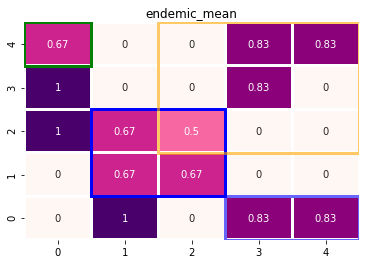

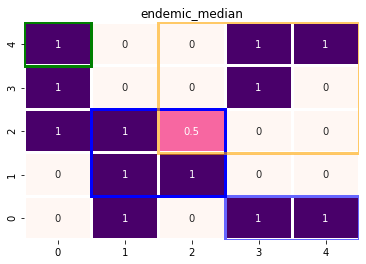

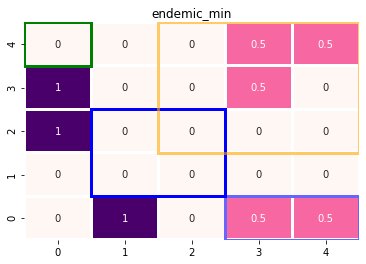

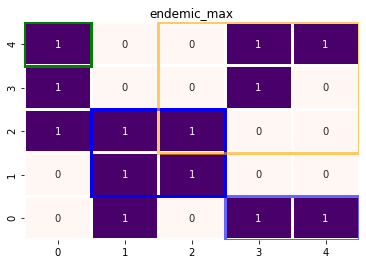

In [18]:
plot_heatmap(signals_with_endemic_non_case.w_endemic_mean.values, "endemic_mean")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_median.values, "endemic_median")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_min.values, "endemic_min")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_max.values, "endemic_max")
plt.show()

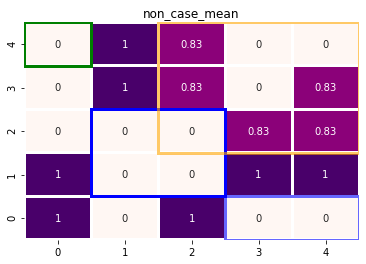

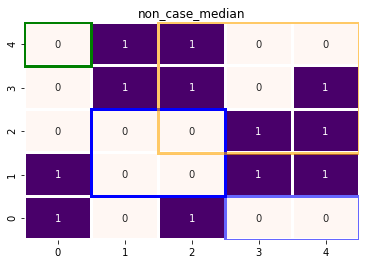

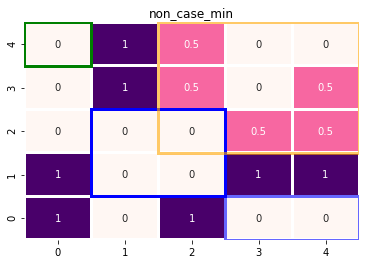

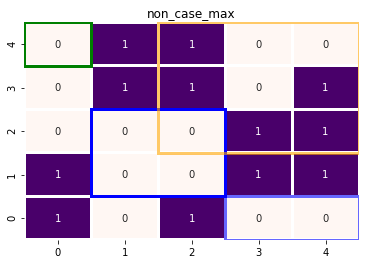

In [19]:
plot_heatmap(signals_with_endemic_non_case.w_non_case_mean.values, "non_case_mean")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_median.values, "non_case_median")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_min.values, "non_case_min")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_max.values, "non_case_max")
plt.show()

## Score calculation (regression)

In [20]:
def create_signal_dist(agg):
    # p^ (s_j|x) = w(s, x) / sum_s (w(s,x))
    p_signal = (
        signals_with_endemic_non_case.loc[
            :, ["w_A", "w_B", "w_C", f"w_non_case_{agg}", f"w_endemic_{agg}"]
        ]
        .div(
            signals_with_endemic_non_case.loc[
                :, ["w_A", "w_B", "w_C", f"w_non_case_{agg}", f"w_endemic_{agg}"]
            ].sum(axis=1),
            axis=0,
        )
        .values
    )

    signals_with_endemic_non_case.loc[
        :, ["p_A", "p_B", "p_C", "p_non_case", "p_endemic"]
    ] = p_signal

    signals_long = signals_with_endemic_non_case.melt(
        id_vars=["x1", "x2"],
        value_vars=["p_A", "p_B", "p_C", "p_non_case", "p_endemic"],
        var_name="s_j",
        value_name="prior",
    ).assign(s_j=lambda x: x["s_j"].str.replace("p_", ""))
    return signals_long

In [26]:
# p^ (s_j|x) = w(s, x) / sum_s (w(s,x))
p_signal = (
    signals_with_endemic_non_case.loc[
        :, ["w_A", "w_B", "w_C", "w_non_case_min", "w_endemic_min"]
    ]
    .div(
        signals_with_endemic_non_case.loc[
            :, ["w_A", "w_B", "w_C", "w_non_case_min", "w_endemic_min"]
        ].sum(axis=1),
        axis=0,
    )
    .values
)

signals_with_endemic_non_case.loc[
    :, ["p_A", "p_B", "p_C", "p_non_case", "p_endemic"]
] = p_signal

signals_long_min = signals_with_endemic_non_case.melt(
    id_vars=["x1", "x2"],
    value_vars=["p_A", "p_B", "p_C", "p_non_case", "p_endemic"],
    var_name="s_j",
    value_name="prior",
).assign(s_j=lambda x: x["s_j"].str.replace("p_", ""))

In [21]:
signals_long_min = create_signal_dist("min")
signals_long_max = create_signal_dist("max")
signals_long_mean = create_signal_dist("mean")
signals_long_median = create_signal_dist("median")

In [22]:
# p^(d_i | s_j, x)
nested_list = list(
    product(
        product(range(5), range(5)),
        product(
            ["one", "two", "three", "endemic", "non_case"],
            ["A", "B", "C", "endemic", "non_case"],
        ),
    )
)
d_s_given_x = pd.DataFrame(
    [tuple_[0] + tuple_[1] for tuple_ in nested_list],
    columns=["x1", "x2", "d_i", "s_j"],
)

signal_data_indeces = d_s_given_x.query(
    "~(s_j.isin(['endemic', 'non_case']) | d_i.isin(['endemic', 'non_case']))"
).index
d_s_given_x.loc[signal_data_indeces, "posterior"] = 1 / len(
    set(DATA_LABELS) - set(MUST_HAVE_LABELS)
)

non_case_endemic_signal_indeces = d_s_given_x.query("d_i == s_j").index
d_s_given_x.loc[non_case_endemic_signal_indeces, "posterior"] = 1
d_s_given_x = d_s_given_x.fillna(0)

In [23]:
d_s_given_x.head()

,x1,x2,d_i,s_j,posterior
0,0,0,one,A,0.333333
1,0,0,one,B,0.333333
2,0,0,one,C,0.333333
3,0,0,one,endemic,0.000000
4,0,0,one,non_case,0.000000


In [24]:
def create_p_hat_di(d_s_given_x, signals_long):
    # p^(d_i | x) = sum( p^(d_i| s_j, x) p^(s_j, x) )
    p_hat_di = d_s_given_x.merge(signals_long, on=["x1", "x2", "s_j"])
    p_hat_di.loc[:, "p^(d_i)"] = p_hat_di["posterior"] * p_hat_di["prior"]
    p_hat_di = p_hat_di.groupby(["x1", "x2", "d_i"]).agg({"p^(d_i)": sum}).reset_index()
    return p_hat_di

In [55]:
# p^(d_i | x) = sum( p^(d_i| s_j, x) p^(s_j, x) )
p_hat_di = d_s_given_x.merge(signals_long, on=["x1", "x2", "s_j"])

p_hat_di.loc[:, "p^(d_i)"] = p_hat_di["posterior"] * p_hat_di["prior"]

p_hat_di = p_hat_di.groupby(["x1", "x2", "d_i"]).agg({"p^(d_i)": sum}).reset_index()

In [28]:
p_hat_di_min = create_p_hat_di(d_s_given_x, signals_long_min)
p_hat_di_max = create_p_hat_di(d_s_given_x, signals_long_max)
p_hat_di_mean = create_p_hat_di(d_s_given_x, signals_long_mean)
p_hat_di_median = create_p_hat_di(d_s_given_x, signals_long_median)

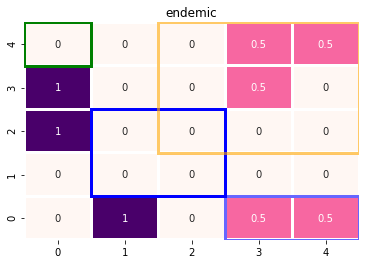

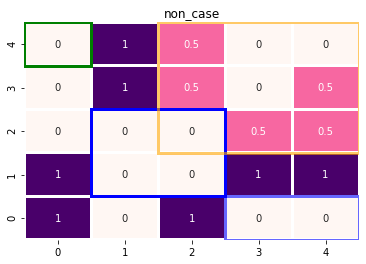

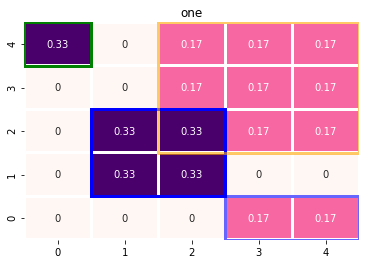

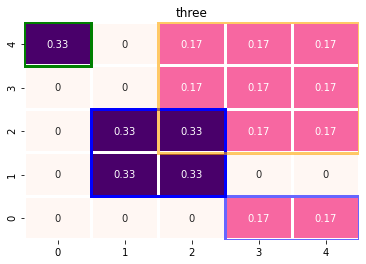

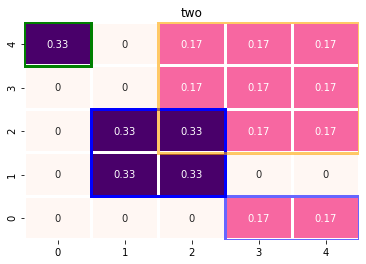

In [30]:
for datalabel in p_hat_di_min["d_i"].unique():
    plot_heatmap(
        p_hat_di_min.query("d_i==@datalabel").loc[:, ["p^(d_i)"]].values,
        datalabel,
    )
    plt.show()

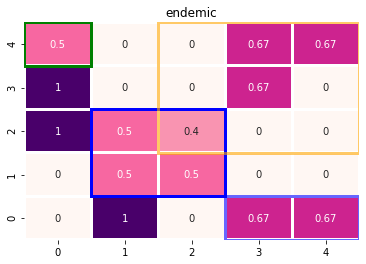

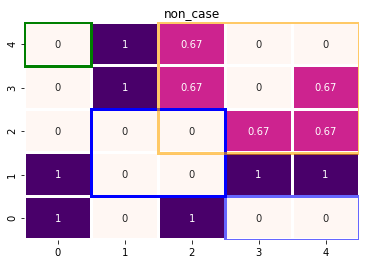

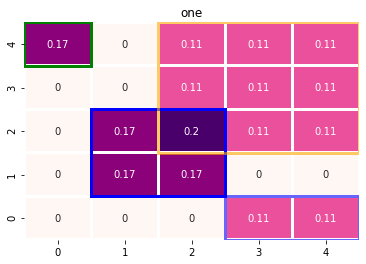

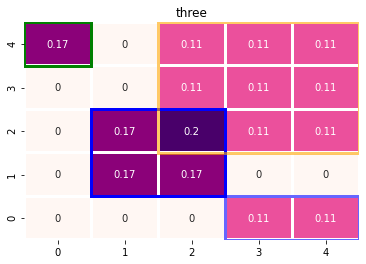

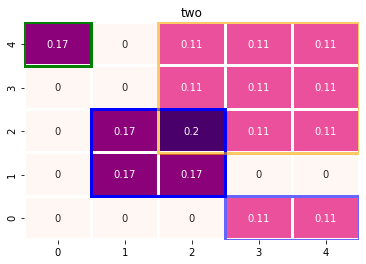

In [31]:
for datalabel in p_hat_di_max["d_i"].unique():
    plot_heatmap(
        p_hat_di_max.query("d_i==@datalabel").loc[:, ["p^(d_i)"]].values,
        datalabel,
    )
    plt.show()

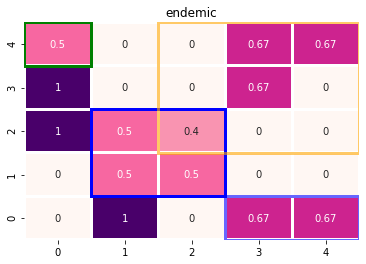

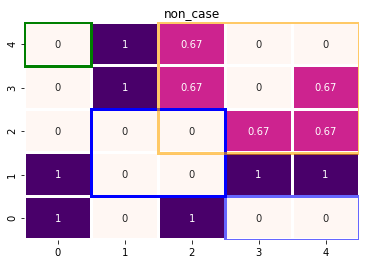

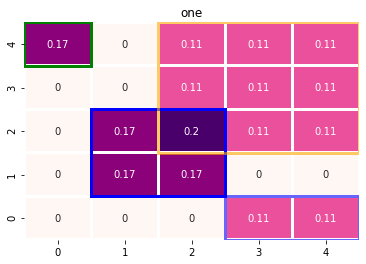

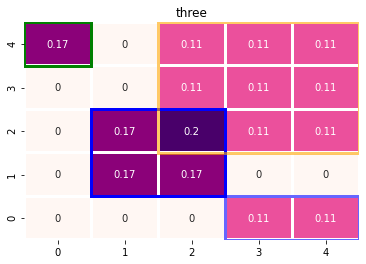

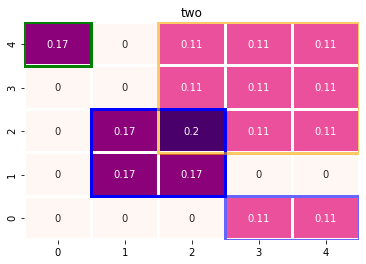

In [32]:
for datalabel in p_hat_di_max["d_i"].unique():
    plot_heatmap(
        p_hat_di_max.query("d_i==@datalabel").loc[:, ["p^(d_i)"]].values,
        datalabel,
    )
    plt.show()

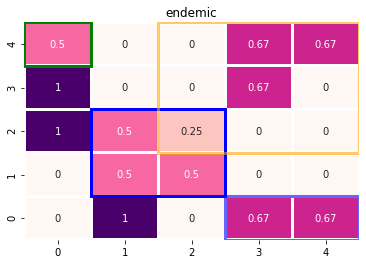

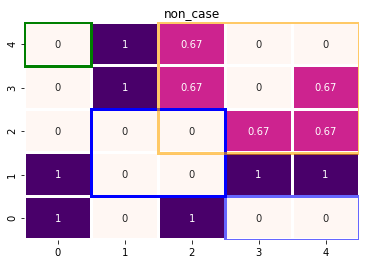

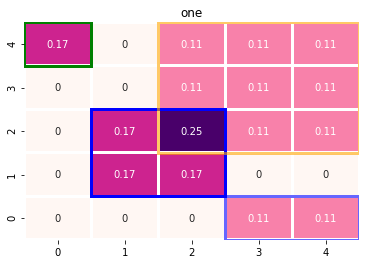

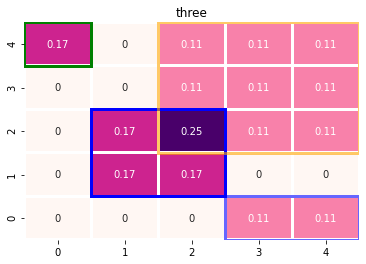

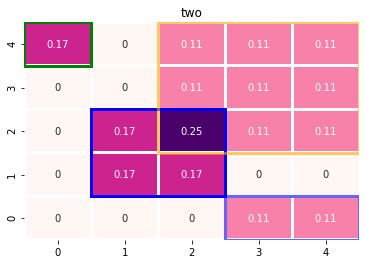

In [33]:
for datalabel in p_hat_di_median["d_i"].unique():
    plot_heatmap(
        p_hat_di_median.query("d_i==@datalabel").loc[:, ["p^(d_i)"]].values,
        datalabel,
    )
    plt.show()

In [34]:
p_di = df_padded.melt(id_vars=["x1", "x2"], var_name="d_i", value_name="p(d_i)")

In [35]:
p_di.head()

,x1,x2,d_i,p(d_i)
0,0.0,0.0,one,0.0
1,0.0,1.0,one,0.0
2,0.0,2.0,one,0.0
3,0.0,3.0,one,0.0
4,0.0,4.0,one,0.0


In [36]:
eval_df_min = p_di.merge(p_hat_di_min, on=["x1", "x2", "d_i"])
eval_df_max = p_di.merge(p_hat_di_max, on=["x1", "x2", "d_i"])
eval_df_mean = p_di.merge(p_hat_di_mean, on=["x1", "x2", "d_i"])
eval_df_median = p_di.merge(p_hat_di_median, on=["x1", "x2", "d_i"])

In [37]:
def KL(P, Q):
    """Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0."""
    epsilon = 0.00001

    P = P + epsilon
    Q = Q + epsilon

    divergence = np.sum(P * np.log(P / Q))
    return divergence

In [44]:
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(KL(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values))

46.362227622724646
36.20520614304559
36.41065535744034
36.187519811555894


In [45]:
from scipy.stats import entropy

In [52]:
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(entropy(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values))

inf
inf
inf
inf


In [40]:
from sklearn import metrics

In [67]:
eval_df_median.apply(lambda x: KL(x["p(d_i)"], x["p^(d_i)"]), axis=1).mean()

0.28950015849244715

In [41]:
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(
        metrics.mutual_info_score(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values)
    )

0.29634980972036773
0.3025208486903207
0.305239233279047
0.3025208486903207


In [69]:
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(metrics.r2_score(eval_df["p(d_i)"].values, eval_df["p^(d_i)"].values))

0.3965014577259477
0.45069970845481055
0.4436151603498544
0.4504373177842568


In [70]:
for eval_df in [eval_df_min, eval_df_mean, eval_df_max, eval_df_median]:
    print(np.sqrt(np.mean((eval_df["p(d_i)"].values - eval_df["p^(d_i)"].values) ** 2)))

0.30331501776206204
0.2893748050155331
0.2912349185413346
0.28944391128123215


In [71]:
eval_df_min

,x1,x2,d_i,p(d_i),p^(d_i)
0,0.0,0.0,one,0.0,0.000000
1,0.0,1.0,one,0.0,0.000000
2,0.0,2.0,one,0.0,0.000000
3,0.0,3.0,one,0.0,0.000000
4,0.0,4.0,one,0.0,0.333333
...,...,...,...,...,...
120,4.0,0.0,non_case,0.0,0.000000
121,4.0,1.0,non_case,1.0,1.000000
122,4.0,2.0,non_case,1.0,0.500000
123,4.0,3.0,non_case,1.0,0.500000


### How to score when algo is a classifier
- We look into data distribution and set a cut-off based on data distribution. We assume that the non-outbreak numbers are highest around 0. This peak will flatten when we move away from 0. There we set a cut-off when the next peak is about to start (probably a outbreak cluster)
- Discretize p(d_i) into bins and predict vector of bins
- p(d_i) \element of {0,1} -> confusion matrix

R = [0,1]

B = {0,1}
- p \element R AND p^ \element R -> like the lower, when threshold for p^ is set to e.g., 0.5
- p \element R AND p^ \element B ->
- p \element B AND p^ \element R -> easy/known/ROC/AUC
- p \element B AND p^ \element B -> easy

## TODO:
- Regressions-Fall: Verschiedene Scores rechnen
    - MSE
    - RMSE
    - U-Test (Whitney) oder ähnliches
    - Andere Scores. Theorie checken

- Classifikations-Fall (Wie komme ich von einem kontinuierlichen Wert der Daten auf einen binären
    - zB clustering, cut-off, diskretisierung
    - Confusion Matrix

- KL, Entropy, MI (Wie macht es inhatlich Sinn die Entropie zu berechnen, gegeben den verschiedenen Zellen und DataLabels)